# BaseLine performance: Supervised Learning on labeled data 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## MNIST Dataset

In [8]:
# Load the labeled data from the .npz file
data = np.load('./Saved_Data/labeled_dataset_MNIST.npz')
labeled_images = data['images']
labled_labels = data['labels']

# Convert data to PyTorch tensors
labeled_images = torch.tensor(labeled_images, dtype=torch.float32)
labled_labels = torch.tensor(labled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
labeled_dataset = TensorDataset(labeled_images, labled_labels)
labeled_dataloaderMnist = DataLoader(labeled_dataset, batch_size=10, shuffle=True)

In [9]:
# Load the un-labeled data from the .npz file
data = np.load('./Saved_Data/unlabeled_dataset_MNIST.npz')
unlabeled_images = data['images']
unlabeled_labels = data['labels']

# Convert data to PyTorch tensors
unlabeled_images = torch.tensor(unlabeled_images, dtype=torch.float32)
unlabeled_labels = torch.tensor(unlabeled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
unlabeled_dataset = TensorDataset(unlabeled_images, unlabeled_labels)
unlabeled_dataloaderMnist = DataLoader(unlabeled_dataset, batch_size=50, shuffle=True)

In [10]:
class MnistNet(nn.Module):

    def __init__(self):

        super(MnistNet,self).__init__()
        self.flatten = nn.Flatten()
        self.fullyConnectedLayer = nn.Sequential(
            
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200,10)
        )

    def forward(self, input):
        
        input = self.flatten(input)
        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput
    

In [11]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [12]:
def trainAndPlot(model, labeled_loader,unlabeled_loader, num_of_epochs, readingAtEpoch, lr = 0.002):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)

    training_losses = []
    train_accuracies = []
    test_accuracies = []

    # Variable to store the best test accuracy
    best_test_accuracy = 0.0
    best_epoch = 0
    
    # Training loop
    for epoch in range(num_of_epochs):
        for images, labels in labeled_loader:
            optimizer.zero_grad()     
            output = model(images)     
            loss = criterion(output, labels)
            loss.backward()           
            optimizer.step()           

        if epoch % readingAtEpoch==0:
            loss_value = loss.item()
            train_accuracy_value = calculate_accuracy(labeled_loader, model)
            test_accuracy_value = calculate_accuracy(unlabeled_loader, model)

            if test_accuracy_value > best_test_accuracy:
                best_test_accuracy = test_accuracy_value
                best_epoch = epoch

            training_losses.append(loss_value)
            train_accuracies.append(train_accuracy_value)
            test_accuracies.append(test_accuracy_value)

            print(f"Epoch {epoch}: Loss: {loss_value}, "
              f"Training Accuracy: {train_accuracy_value},"
              f"Testing Accuracy: {test_accuracy_value}")
            

    epochs = range(0,num_of_epochs, readingAtEpoch)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Supervised Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')

    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Testing Accuracy')
    plt.ylim(0,110)
    plt.title('Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Epoch 0: Loss: 2.3037936687469482, Training Accuracy: 10.0,Testing Accuracy: 10.0
Epoch 10: Loss: 2.235456943511963, Training Accuracy: 85.0,Testing Accuracy: 61.494949494949495
Epoch 20: Loss: 1.7520618438720703, Training Accuracy: 78.0,Testing Accuracy: 60.525252525252526
Epoch 30: Loss: 1.595284342765808, Training Accuracy: 83.0,Testing Accuracy: 65.05050505050505
Epoch 40: Loss: 1.4787957668304443, Training Accuracy: 89.0,Testing Accuracy: 66.08080808080808
Epoch 50: Loss: 0.7058915495872498, Training Accuracy: 88.0,Testing Accuracy: 68.36363636363636
Epoch 60: Loss: 0.7444072961807251, Training Accuracy: 91.0,Testing Accuracy: 69.56565656565657
Epoch 70: Loss: 0.729010283946991, Training Accuracy: 94.0,Testing Accuracy: 69.78787878787878
Epoch 80: Loss: 0.3567848801612854, Training Accuracy: 96.0,Testing Accuracy: 69.87878787878788
Epoch 90: Loss: 0.17221854627132416, Training Accuracy: 98.0,Testing Accuracy: 70.27272727272727


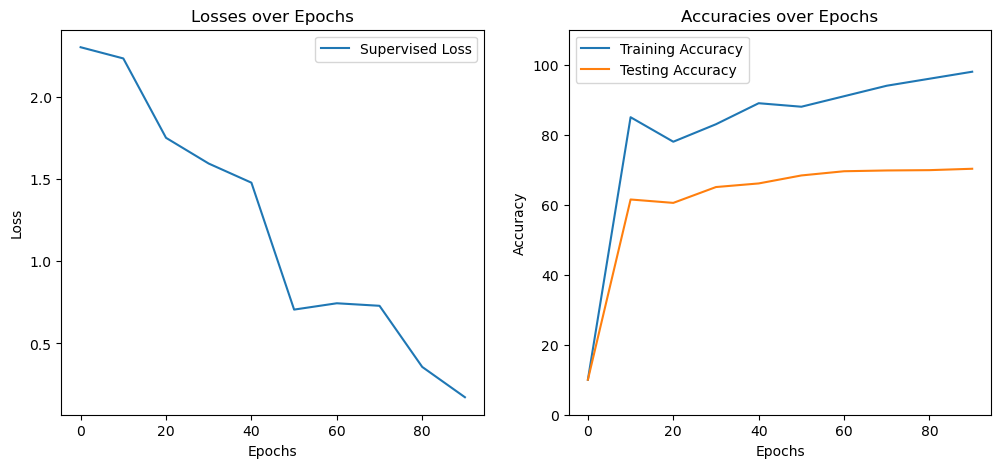

In [13]:
MNIST_EPOCHS = 100
model = MnistNet()
trainAndPlot(model=model, 
          labeled_loader=labeled_dataloaderMnist,
          unlabeled_loader=unlabeled_dataloaderMnist,
           num_of_epochs=MNIST_EPOCHS,
              readingAtEpoch=10,
            )




## Two Moons Dataset

In [14]:
selected_samples = np.load('./Saved_Data/labeled_dataset_TwoMoons.npy')

remaining_samples = np.load('./Saved_Data/unlabeled_dataset_TwoMoons.npy')

# Converting the selected samples and remaining samples into PyTorch tensors
selected_samples_tensor = torch.tensor(selected_samples, dtype=torch.float32)
remaining_samples_tensor = torch.tensor(remaining_samples, dtype=torch.float32)

# Extracting features and labels for both datasets
features_selected = selected_samples_tensor[:, :2]
labels_selected = selected_samples_tensor[:, 2].long()  # converting labels to long for classification

features_remaining = remaining_samples_tensor[:, :2]
labels_remaining = remaining_samples_tensor[:, 2].long()

# Creating TensorDatasets
selected_dataset = TensorDataset(features_selected, labels_selected)
remaining_dataset = TensorDataset(features_remaining, labels_remaining)

# Creating DataLoaders
labeled_dataloaderTM = DataLoader(selected_dataset, batch_size=1)  # small batch size for the small dataset
unlabeled_dataloaderTM = DataLoader(remaining_dataset, batch_size=5)  # larger batch size for the larger dataset

In [15]:
class TwoMoonsNet(nn.Module):

    def __init__(self):

        super(TwoMoonsNet,self).__init__()

        self.fullyConnectedLayer = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10,2)
        )

    def forward(self, input):

        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput

Epoch 0: Loss: 1.1654130220413208, Training Accuracy: 50.0,Testing Accuracy: 50.0
Epoch 10: Loss: 1.0052012205123901, Training Accuracy: 50.0,Testing Accuracy: 50.0
Epoch 20: Loss: 0.8963209390640259, Training Accuracy: 50.0,Testing Accuracy: 50.0
Epoch 30: Loss: 0.8280407190322876, Training Accuracy: 50.0,Testing Accuracy: 50.0
Epoch 40: Loss: 0.7853522300720215, Training Accuracy: 50.0,Testing Accuracy: 51.03092783505155
Epoch 50: Loss: 0.758772611618042, Training Accuracy: 66.66666666666667,Testing Accuracy: 73.71134020618557
Epoch 60: Loss: 0.7424606084823608, Training Accuracy: 83.33333333333333,Testing Accuracy: 81.44329896907216
Epoch 70: Loss: 0.7328536510467529, Training Accuracy: 83.33333333333333,Testing Accuracy: 86.5979381443299
Epoch 80: Loss: 0.7277533411979675, Training Accuracy: 83.33333333333333,Testing Accuracy: 87.11340206185567
Epoch 90: Loss: 0.7257406115531921, Training Accuracy: 83.33333333333333,Testing Accuracy: 87.62886597938144


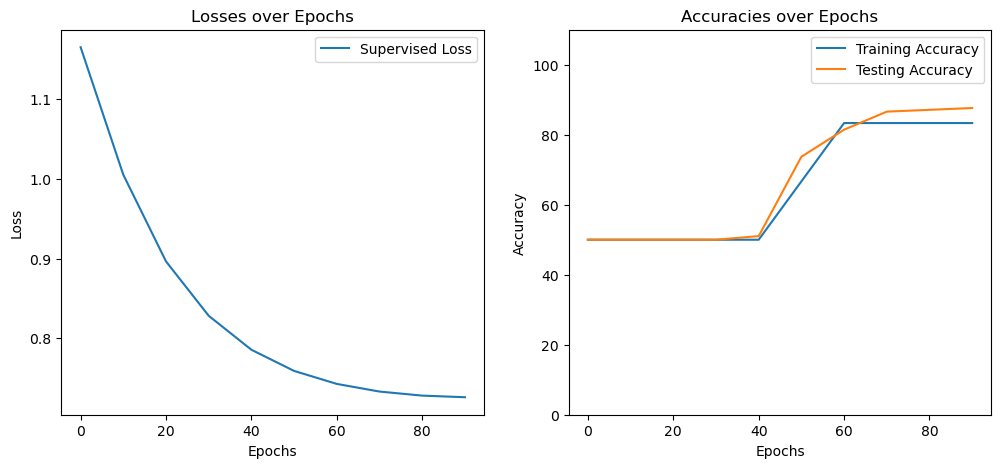

In [16]:
baseModel_TwoMoons = TwoMoonsNet()

EPOCHS = 100


trainAndPlot(model=baseModel_TwoMoons, 
          labeled_loader=labeled_dataloaderTM,
          unlabeled_loader=unlabeled_dataloaderTM,
           num_of_epochs=EPOCHS,
              readingAtEpoch=10,
              lr=0.001
            )


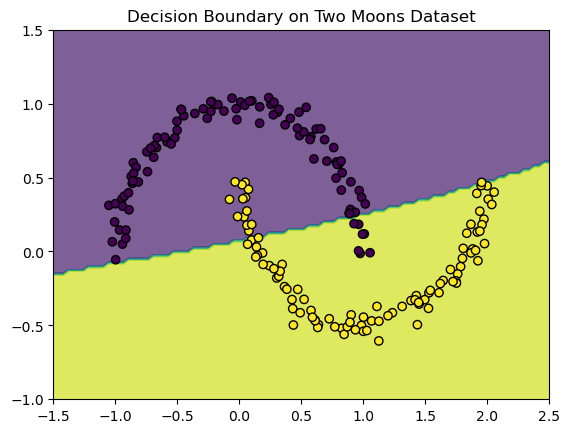

In [17]:
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

baseModel_TwoMoons.eval()
with torch.no_grad():
    predictions = baseModel_TwoMoons(grid_tensor)
    classes = torch.argmax(predictions, dim=1).numpy().reshape(xx.shape)

plt.contourf(xx, yy, classes, alpha=0.7)
plt.scatter(selected_samples[:, 0], selected_samples[:, 1], c=selected_samples[:, 2], edgecolor='k')
plt.scatter(remaining_samples[:, 0], remaining_samples[:, 1], c=remaining_samples[:, 2], edgecolor='k')
plt.title("Decision Boundary on Two Moons Dataset")
plt.show()